In [62]:
# from og_marl.vault_utils.analyse_vault import create_count_information
# from subsample_vault import subsample_smaller_vault
# from plot_oaco import plot_oaco, plot_count_frequencies, plot_reward_variability
from og_marl.vault_utils.analyse_vault import *
import pickle
import matplotlib.pyplot as plt
import numpy as np
from flashbax.vault import Vault
import jax
import jax.numpy as jnp
import numpy as np
import flashbax as fbx
from flashbax.vault import Vault
from scipy.stats import norm
import matplotlib.pyplot as plt
import copy
import flashbax
from flashbax.buffers.trajectory_buffer import TrajectoryBufferState

# Processing coverage information for a multi-agent dataset

In [63]:
# set to False to reduce storage requirements
random_dataset_uid_pos = -2

In [64]:
# rel_dir = "vaults/smac_v1/"

# vault_name = "5m_vs_6m"
# # vault_uids=["Expert","Medium","Medium-Replay","Mixed"]
# # vault_uids=["Replay","Random"]
# # vault_uids=["Good","Medium","Poor"]
# # vault_uids=["Good","Medium","Poor","omiga_Good","omiga_Medium","omiga_Poor","cfcql_Expert","cfcql_Medium","cfcql_Medium-Replay","cfcql_Mixed"]
# vault_uids=["Good","Medium","Poor","cfcql_Expert","cfcql_Medium","cfcql_Medium-Replay"]

# new_vault_name = vault_name+'_120000.vlt'

rel_dir = "vaults/"

# new_vault_name = vault_name+'_120000.vlt'
new_vault_name = "medium_similar"
vault_uids = ["Medium_CFCQL","Medium_OG_MARL"]

# for vault_uid in vault_uids:

    # make a smaller vault - it is easier for memory to handle
    # new_vault_name = subsample_smaller_vault(rel_dir,vault_name,vault_uid,120000)

    # # # for each new vault, store count information at the new vault location
    # keys = create_count_information(rel_dir, new_vault_name, vault_uid)

vltt = vault_name+'.vlt'
returns = analyse_vault(vltt,vault_uids,rel_dir,visualise=True)
returns = analyse_vault(new_vault_name,vault_uids,rel_dir,visualise=True,save=True)
for key in list(returns.keys()):
    print(key+'\t'+str(np.mean(returns[key]))+'\t'+str(np.std(returns[key]))+'\t'+str(np.max(returns[key])))

In [65]:
# just gathering good, medium and poor vaults in a list of unread vaults
def get_all_vaults(rel_dir,vault_name,vault_uids=["Good","Medium","Poor"]):
    vlts = []
    for quality in vault_uids:
        vlts.append(Vault(rel_dir=rel_dir, vault_name=vault_name, vault_uid=quality))
    return vlts

In [66]:
# cumulative summing per-episode
def get_episode_returns_and_term_idxes(vlt):
    all_data = vlt.read()
    offline_data = all_data.experience

    rewards = offline_data['rewards'][0, :, 0]
    print(rewards.shape)
    terminal_flag = offline_data['terminals'][0, :, ...].all(axis=-1)

    # assert terminal_flag[-1]==True

    def scan_cumsum(return_so_far,prev_term_reward):
        term, reward = prev_term_reward
        return_so_far = return_so_far*(1-term)+ reward
        return return_so_far, return_so_far
    
    xs = (terminal_flag[:-1], rewards[1:])
    
    _, cumsums = jax.lax.scan(scan_cumsum, rewards[0],xs)

    term_idxes = np.argwhere(terminal_flag)

    # shift back as we did for the loop
    return cumsums[term_idxes-1], term_idxes

In [67]:
# first store indices of episodes, then sort by episode return.
# outputs return, start, end and vault index in vault list
def sort_concat(returns,eps_ends, ids):

    episode_start_idxes = eps_ends[:-1]+1
    episode_start_idxes = jnp.insert(episode_start_idxes,0,0).reshape(-1,1)
    sorting_idxes = jnp.lexsort(jnp.array([returns[:,0]]), axis=-1)
    # print(sorting_idxes)

    return_start_end = jnp.concatenate([returns,episode_start_idxes.reshape(-1,1),eps_ends,ids],axis=-1)

    # return, start, end sorted by return value ascending
    sorted_return_start_end = return_start_end[sorting_idxes]
    return sorted_return_start_end

In [68]:
# given bin edges and a sorted array of values, get the bin number per value
def get_bin_numbers(sorted_values,bin_edges):
    bin_numbers = np.zeros_like(sorted_values)
    
    def get_bin_number(bin_num,value):
        is_overflowing = value>bin_edges[bin_num]

        if is_overflowing:
            bin_num += 1
            is_doubly_overflowing = value>bin_edges[bin_num]
            if is_doubly_overflowing:
                bin_num = get_bin_number(bin_num,value)
            
        return bin_num
    
    bin_bookmark = 0

    for i,val in enumerate(sorted_values):
        bin_bookmark = get_bin_number(bin_bookmark,val)
        bin_numbers[i] = bin_bookmark

    return bin_numbers

In [69]:
# sample from pdf according to heights
# BIG NOTE: CHECK THE DISPARITY, OTHERWISE YOUR DISTRIBUTION WILL BE TOO MUCH
def episode_idxes_sampled_from_pdf(pdf,bar_heights):
    num_to_sample = np.round(pdf).astype(int)
    sample_range_edges = np.concatenate([[0],np.cumsum(bar_heights)])

    assert num_to_sample.shape==bar_heights.shape

    target_sample_idxes = []
    for i,n_sample in enumerate(num_to_sample):
            sample_base = np.arange(sample_range_edges[i],sample_range_edges[i+1])
            print(sample_base)
            if n_sample<=0:
                 pass
            # if we sample more than all in the bar
            else:
                if n_sample>=bar_heights[i]:
                    sample_rest = np.random.choice(sample_base,n_sample-bar_heights[i],replace=True)
                    sample = np.concatenate([sample_base,sample_rest])
                else:
                    sample = np.random.choice(sample_base,n_sample,replace=True) #make false for no replace
                target_sample_idxes = target_sample_idxes+list(np.sort(sample))
    return target_sample_idxes

In [70]:
def sanity_check(sampled_idxes,returns):
    vals = np.array([returns[i] for i in sampled_idxes])
    return np.mean(vals), np.std(vals)

def preprocess(rel_dir,vault_name):
    vlts = get_all_vaults(rel_dir, vault_name)

    # get returns, term idxes for each episode per vault
    returns_list = []
    episode_end_list = []
    vault_ids = []
    for j,vault in enumerate(vlts):
        print(j)
        returns, episode_end_idxes = get_episode_returns_and_term_idxes(vault)
        returns_list.append(returns)
        episode_end_list.append(episode_end_idxes)
        vault_ids.append(jnp.zeros_like(returns)+j)

    # make np compatible
    all_returns = jnp.concatenate(returns_list)
    all_episode_end_idxes = jnp.concatenate(episode_end_list)
    all_vault_ids = jnp.concatenate(vault_ids)

    # concatenate then sort all results
    all_sorted_return_start_end = sort_concat(all_returns,all_episode_end_idxes, all_vault_ids)
    return vlts, all_sorted_return_start_end

def preprocess_vault(rel_dir,vault_name, vault_uid):
    vault = Vault(rel_dir=rel_dir, vault_name=vault_name,vault_uid=vault_uid)

    returns, episode_end_idxes = get_episode_returns_and_term_idxes(vault)
    
    all_sorted_return_start_end = sort_concat(returns,episode_end_idxes, jnp.zeros_like(returns))
    return vault, all_sorted_return_start_end

def bin_processed_data(all_sorted_return_start_end, n_bins=500):
    # get bin edges, including final endpoint
    bin_edges = jnp.linspace(start=min(min(all_sorted_return_start_end[:,0]),0), stop = max(all_sorted_return_start_end[:,0]), num=n_bins,endpoint=True)
    print(all_sorted_return_start_end.shape[0])

    # get bin numbers
    bin_numbers = get_bin_numbers(all_sorted_return_start_end[:,0], bin_edges)
    print(bin_numbers.shape[0])

    bar_labels, bar_heights= np.unique(bin_numbers,return_counts=True)

    padded_heights = np.zeros(n_bins)
    for bar_l, bar_h in zip(bar_labels,bar_heights):
        padded_heights[int(bar_l)] = bar_h

    return bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers

In [71]:
# get base vaults
vlt_1, vlt1_sorted_return_start_end = preprocess_vault(rel_dir=rel_dir, vault_name=new_vault_name, vault_uid = vault_uids[0])
vlt_2, vlt2_sorted_return_start_end = preprocess_vault(rel_dir=rel_dir, vault_name=new_vault_name, vault_uid=vault_uids[1])

Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/medium_similar/Medium_CFCQL
(140073,)
Loading vault found at /home/louise/workspace/og-marl/development/clean_utils/vaults/medium_similar/Medium_OG_MARL
(134985,)


4992
4992
[   8   16   27   40   64  144   72  176  152  360  192  384  352  352
   72  248  272  232  192  173  224  136 1104]
4992
4992
[   8   16   27   40   64  144   72  176  152  360  192  384  352  352
   72  248  272  232  192  173  224  136 1104]


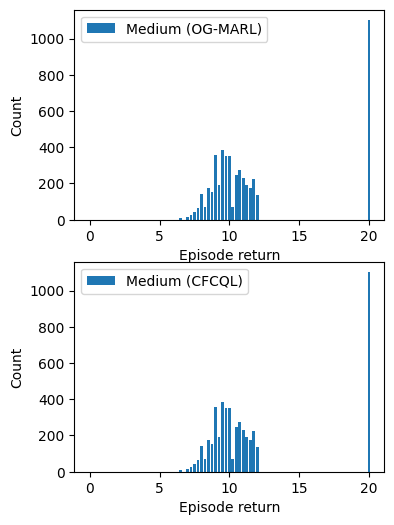

In [94]:
names = ["Medium (OG-MARL)","Medium (CFCQL)"]

fig, ax  = plt.subplots(2,1,figsize=(4,6))

for i,vlt_info in enumerate([vlt1_sorted_return_start_end,vlt2_sorted_return_start_end]):
    bar_labels, bar_heights, padded_heights, bin_edges, bin_numbers = bin_processed_data(vlt_info,n_bins=81)
    ax[i].bar(bin_edges,padded_heights, label=names[i],width=0.2,)
    ax[i].set_ylabel("Count")
    ax[i].set_xlabel("Episode return")
    
    print(bar_heights)
    ax[i].legend()
plt.savefig("medium_hists.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [72]:
for i,vlt_info in enumerate([vlt1_sorted_return_start_end,vlt2_sorted_return_start_end]):
    print(np.mean(vlt_info[:,0]))
    print(np.std(vlt_info[:,0]))


12.052559
4.360752
12.052559
4.360751


In [5]:
import pandas as pd
import seaborn as sns


def plot_oaco(rel_dir,vault_name,vault_uids,random_dataset_pos=-2,norm_wrt_state=False):
    num_unique = {}
    num_tot = []
    for uid in vault_uids:
        with open(rel_dir+vault_name+"/"+uid+"/number_unique.pickle","rb") as f:
            num_unique[uid] = pickle.load(f)
        
        with open(rel_dir+vault_name+"/"+uid+"/timesteps.pickle","rb") as f:
            tot = pickle.load(f)
        num_tot.append(tot)

    unique_df = pd.DataFrame(num_unique)
    unique_df.transpose

    fig, ax = plt.subplots(1,1,figsize=(13,4))

    print(num_tot)

    unique_df = unique_df.div(num_tot,axis=1)

    # normalise wrt random if random dataset exists
    if random_dataset_pos!=-2:
        unique_df = unique_df.div(unique_df.iloc[:,random_dataset_pos],axis=0)

    # normalise wrt random if random dataset exists
    if norm_wrt_state:
        unique_df = unique_df.div(unique_df.iloc[-1,:],axis=1)

    ax = sns.heatmap(unique_df,annot=True,fmt='.2f',square=False)
    for i in range(4):
        ax.axvline(2*i, color='white', lw=5)
    # plt.title(vault_name)
    plt.xticks(rotation=30, ha='right')
    plt.savefig(rel_dir+"/"+vault_name+"/"+"OACo_heatmap.pdf",format='pdf',bbox_inches='tight')
    plt.show()
    return

In [16]:

def plot_oaco(rel_dir,vault_name,vault_uids,random_dataset_pos=-2,norm_wrt_state=False):
    num_unique = {}
    num_tot = []
    for uid in vault_uids:
        with open(rel_dir+vault_name+"/"+uid+"/number_unique.pickle","rb") as f:
            num_unique[uid] = pickle.load(f)
        
        with open(rel_dir+vault_name+"/"+uid+"/timesteps.pickle","rb") as f:
            tot = pickle.load(f)
        num_tot.append(tot)

    unique_df = pd.DataFrame(num_unique)
    unique_df.transpose

    print(unique_df['Good'])
    unique_df.iloc[:5,:] = unique_df.iloc[:5,:].div(unique_df.iloc[-2,:],axis=1)
    unique_df.iloc[5,:] = unique_df.iloc[5,:].div(unique_df.iloc[-1,:])

    # unique_df = unique_df.div(unique_df.iloc[:,random_dataset_pos],axis=0)

    fig, ax = plt.subplots(1,1,figsize=(13,4))

    print(num_tot)

    unique_df.iloc[-1,:] = unique_df.iloc[-1,:].div(num_tot)

    # normalise wrt random if random dataset exists
    if random_dataset_pos!=-2:
        unique_df = unique_df.div(unique_df.iloc[:,random_dataset_pos],axis=0)

    # normalise wrt random if random dataset exists
    if norm_wrt_state:
        unique_df = unique_df.div(unique_df.iloc[-1,:],axis=1)

    ax = sns.heatmap(unique_df,annot=True,fmt='.2f',square=False)
    for i in range(4):
        ax.axvline(2*i, color='white', lw=5)
    # plt.title(vault_name)
    plt.xticks(rotation=30, ha='right')
    plt.savefig(rel_dir+"/"+vault_name+"/"+"OACo_heatmap.pdf",format='pdf',bbox_inches='tight')
    plt.show()
    return

agent_0     82690
agent_1     83919
agent_2     84327
agent_3     79972
agent_4     81977
joint      100845
state      102291
Name: Good, dtype: int64
[119974, 119986, 119989, 119974, 119998, 118404]


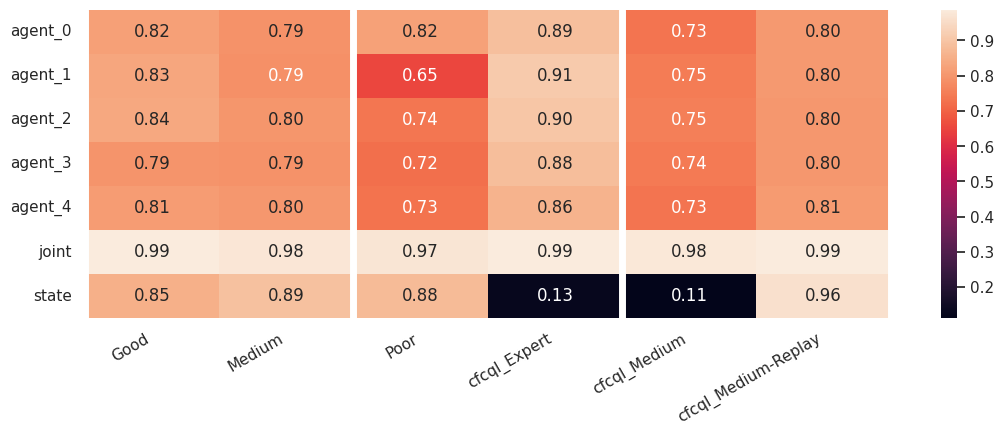

In [17]:

# vault_uids=["Good","cfcql_Expert","Medium","cfcql_Medium","Poor","cfcql_Medium-Replay"]
plot_oaco(rel_dir,new_vault_name,vault_uids,-2,False)

In [15]:
def plot_top_five(rel_dir,vault_name,vault_uids): 

    colors = {
            'death':'black',
            'misc repeated':'orange',
            'non-repeated':'yellow',
            '0':'green',
            '1':'blue',
            '2':'turquoise',
            '3':'red',
            '4':'purple',
            }
    num_unique = {}
    top_5_vals = {}
    top_5_counts = {}

    for uid in vault_uids:
        sizes = {}
        labels = {}

        with open(rel_dir+"/"+vault_name+"/"+uid+"/number_unique.pickle","rb") as f:
            num_unique[uid] = pickle.load(f)

        with open(rel_dir+"/"+vault_name+"/"+uid+"/top_five.pickle","rb") as f:
           (top_5_vals[uid], top_5_counts[uid]) = pickle.load(f)

        labels_dict = {}
        sizes_dict = {}
        for key in list(num_unique[uid].keys()):
            sizes = []
            labels = []

            sizes.append(num_unique[uid][key])
            labels.append('non-repeated')

            death_state = -2
            states_in_top_5 = []
            for i,val in enumerate(top_5_vals[uid][key]):
                # print(val)
                if not val.astype(bool).any():
                    death_state = i

                    sizes.append(top_5_counts[uid][key][i])
                    print(top_5_counts[uid][key][i])
                    labels.append("death")
                else :
                    # states_in_top_5.append(val)
                    sizes.append(top_5_counts[uid][key][i])
                    # labels.append(top_5_vals[uid][key][i])
                    labels.append(str(i))
            # print(tt(key)
            # prinop_5_vals[uid][key])
            

            # todo get exact numberprint(sum(sizes[key]))
            sizes.append(120000-sum(sizes))
            labels.append("misc repeated")

            labels_dict[key] = labels
            sizes_dict[key] = sizes

            sizes_offset = np.cumsum(sizes)-sizes

            # plt.pie(sizes, labels=labels)
            # plt.title(str(key)+str(uid))
            # plt.show()
            for i in range(len(sizes)):
                plt.bar([key],sizes[i], 0.4, bottom=sizes_offset[i],color=colors[labels[i]])
    
        plt.title(uid)
        plt.show()
    
    return

In [6]:
def plot_top_five(rel_dir,vault_name,vault_uids): 

    colors = {
            'death':'black',
            'misc repeated':'orange',
            'non-repeated':'yellow',
            '0':'green',
            '1':'blue',
            '2':'turquoise',
            '3':'red',
            '4':'purple',
            }
    
    num_unique = {}
    top_5_vals = {}
    top_5_counts = {}

    for uid in vault_uids:
        sizes = {}
        labels = {}

        with open(rel_dir+"/"+vault_name+"/"+uid+"/number_unique.pickle","rb") as f:
            num_unique[uid] = pickle.load(f)

        with open(rel_dir+"/"+vault_name+"/"+uid+"/top_five.pickle","rb") as f:
           (top_5_vals[uid], top_5_counts[uid]) = pickle.load(f)

        labels_dict = {}
        sizes_dict = {}
        for key in list(num_unique[uid].keys()):
            sizes = []
            labels = []

            sizes.append(num_unique[uid][key])
            labels.append('non-repeated')

            death_state = -2
            states_in_top_5 = []
            for i,val in enumerate(top_5_vals[uid][key]):
                # print(val)
                if not val.astype(bool).any():
                    death_state = i

                    sizes.append(top_5_counts[uid][key][i])
                    print(top_5_counts[uid][key][i])
                    labels.append("death")
                elif not (val in states_in_top_5):
                    states_in_top_5.append(val)
                    sizes.append(top_5_counts[uid][key][i])
                    # labels.append(top_5_vals[uid][key][i])
                    labels.append(str(i))

            # prinop_5_vals[uid][key])
            

            # todo get exact numberprint(sum(sizes[key]))
            sizes.append(120000-sum(sizes))
            labels.append("misc repeated")

            labels_dict[key] = labels
            sizes_dict[key] = sizes

            sizes_offset = np.cumsum(sizes)-sizes

            # plt.pie(sizes, labels=labels)
            # plt.title(str(key)+str(uid))
            # plt.show()
            for i in range(len(sizes)):
                plt.bar([key],sizes[i], 0.4, bottom=sizes_offset[i],color=colors[labels[i]])
    
        plt.title(uid)
        plt.show()
    
    return

18297
16712
16359
20940
18967


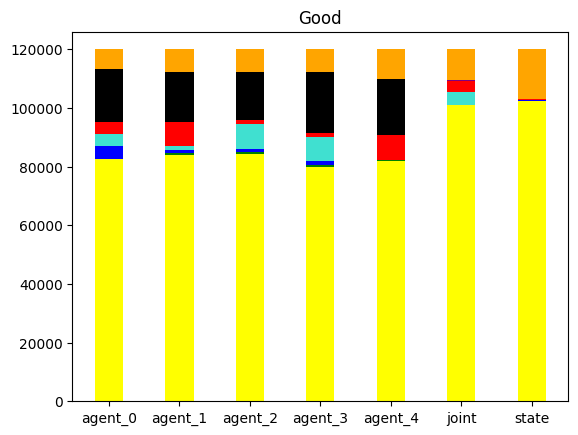

20293
20774
19797
20477
19863


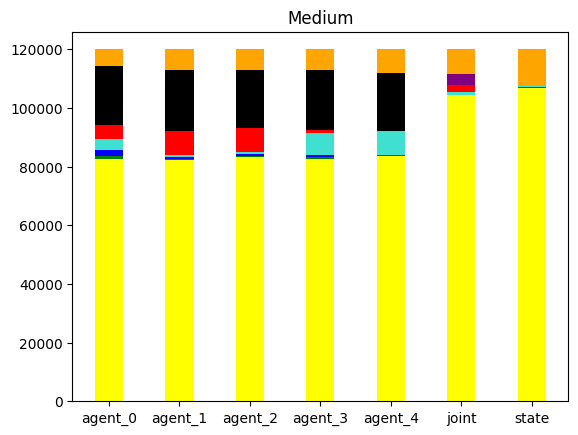

17230
34795
25968
28042
27442


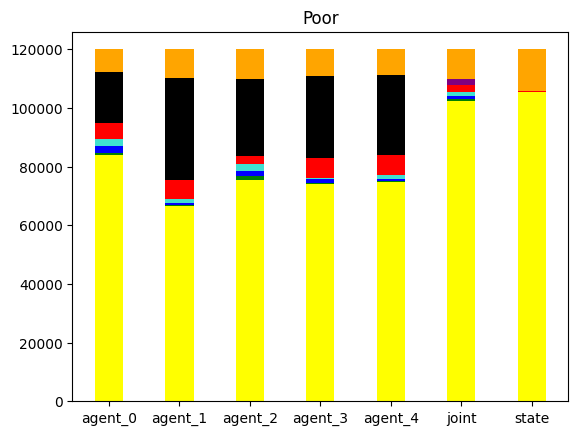

12817
10213
11706
13591
16004


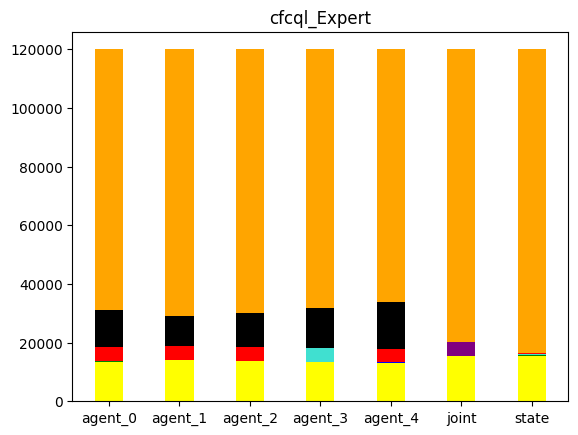

26400
24831
24297
25616
25992


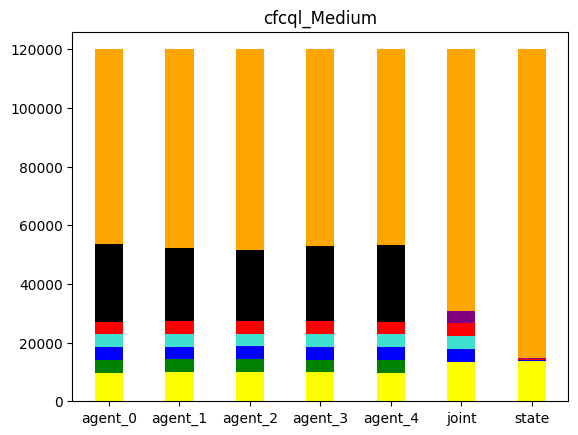

22230
22100
22448
22276
21815


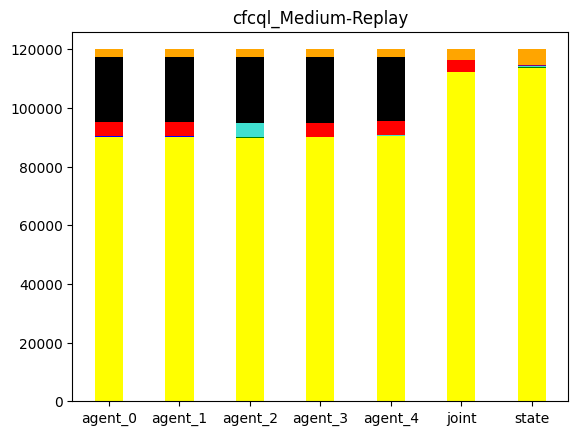

In [16]:
plot_top_five(rel_dir,new_vault_name,vault_uids)

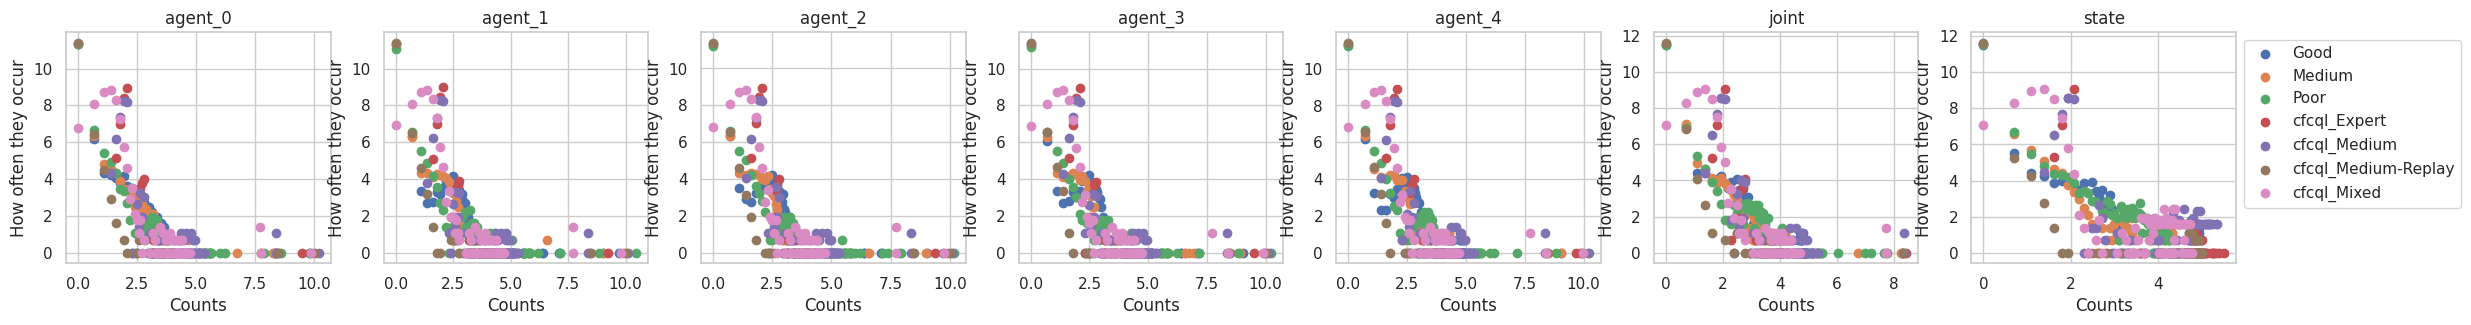

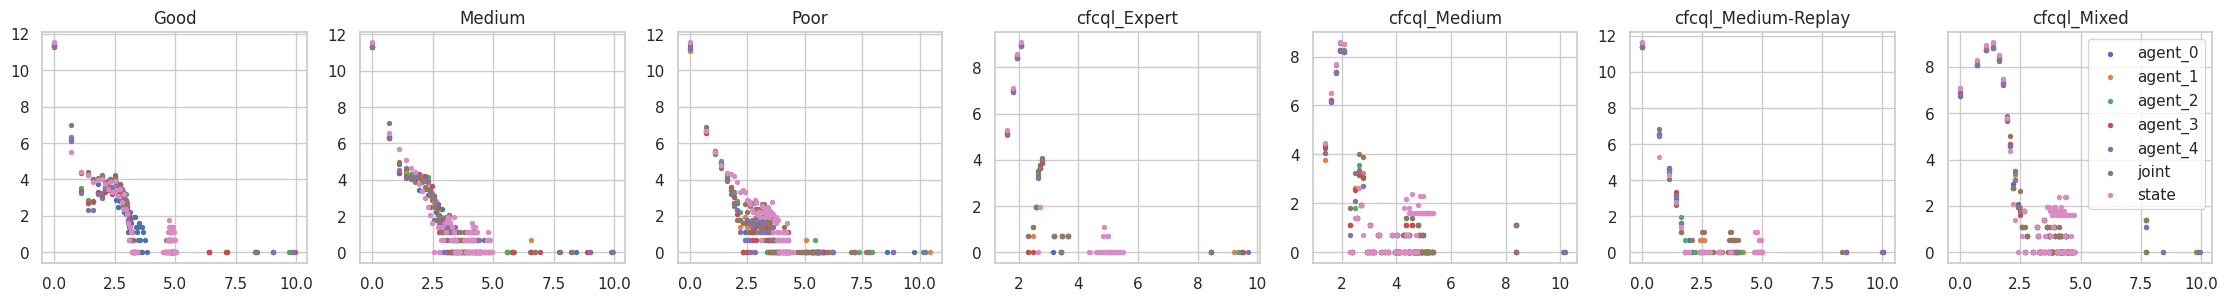

In [32]:
plot_count_frequencies(rel_dir,new_vault_name,vault_uids)

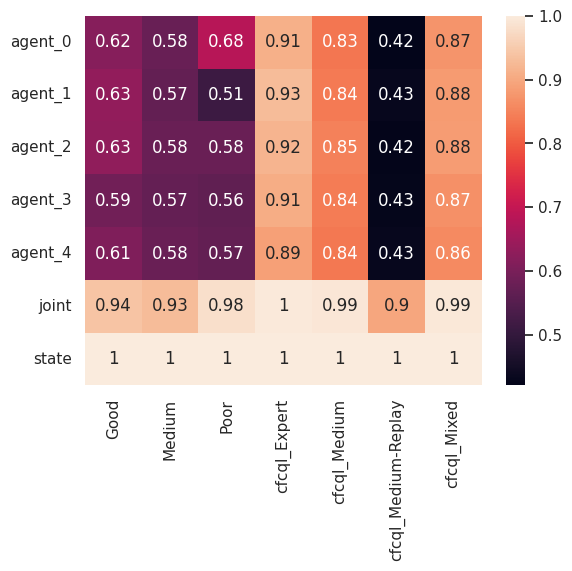

In [33]:
plot_reward_variability(rel_dir,new_vault_name,vault_uids)

In [34]:
def plot_reward_repeat_correlation(rel_dir,vault_name,vault_uids):
    num_unique = {}
    probs = {}
    for uid in vault_uids:
        with open(rel_dir+"/"+vault_name+"/"+uid+"/number_unique.pickle","rb") as f:
            num_unique[uid] = pickle.load(f)

        with open(rel_dir+"/"+vault_name+"/"+uid+"/processed_reward_info.pickle","rb") as f:
            (probs[uid], _) = pickle.load(f)

        plt.scatter(num_unique[uid].values(),probs[uid].values(),label=str(uid))
        plt.scatter(num_unique[uid]['state'],probs[uid]['state'],marker='o',facecolors='none',edgecolors='black')

        # maybe times rewards by any 2 -> prob of getting contradicting data

    plt.legend(bbox_to_anchor=(1,1))
    plt.show()
    return

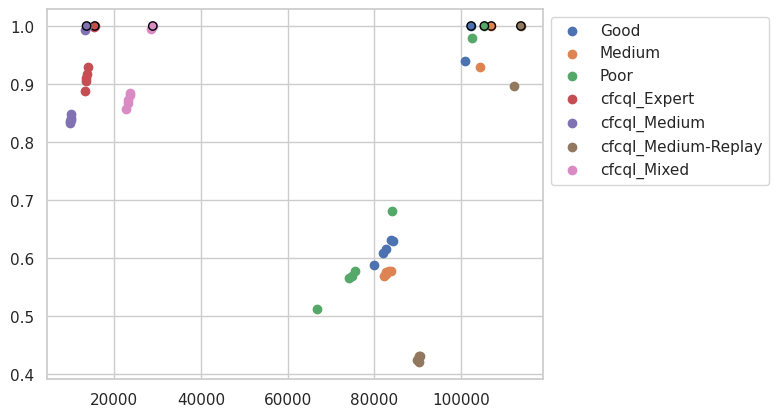

In [35]:
plot_reward_repeat_correlation(rel_dir,new_vault_name,vault_uids)